In [2]:
import config
from bs4 import BeautifulSoup as BS
import mysql.connector
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import *
import time
import re
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import KNNBasic
from surprise.model_selection import GridSearchCV

from sklearn.metrics.pairwise import cosine_similarity

In [34]:
df = pd.read_csv('updated_df.csv', index_col=0)

In [35]:
df.head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,cup_size
0,fit,420272,34,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,d
1,fit,273551,34,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,b
3,fit,909926,34,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,c
4,fit,151944,34,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,b
5,fit,734848,32,364092,138lbs,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68.0,8,45.0,b


In [38]:
#### change weight column to drop 'lbs'
df['weight'] = df['weight'].str.split('\D+')
df['weight'] = df['weight'].apply(lambda x:x[0])
df['weight'] = df['weight'].astype('int32')

In [39]:
df.head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,cup_size
0,fit,420272,34,2260466,137,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,d
1,fit,273551,34,153475,132,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,b
3,fit,909926,34,126335,135,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,c
4,fit,151944,34,616682,145,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,b
5,fit,734848,32,364092,138,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68.0,8,45.0,b


In [40]:
### remove outlier from "rented_for" columns
condition2 = df['rented_for'] != 'party: cocktail'
df = df[condition2]

In [41]:
df.head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,cup_size
0,fit,420272,34,2260466,137,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,d
1,fit,273551,34,153475,132,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,b
3,fit,909926,34,126335,135,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,c
4,fit,151944,34,616682,145,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,b
5,fit,734848,32,364092,138,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68.0,8,45.0,b


In [8]:
df.category.value_counts()

dress         92884
gown          44381
sheath        19316
shift          5365
jumpsuit       5184
              ...  
caftan            4
sweatpants        2
overcoat          2
crewneck          1
buttondown        1
Name: category, Length: 68, dtype: int64

In [12]:
df.category.unique()

array(['romper', 'gown', 'sheath', 'dress', 'leggings', 'top', 'jumpsuit',
       'sweater', 'jacket', 'shirtdress', 'maxi', 'shift', 'pants',
       'shirt', 'mini', 'skirt', 'pullover', 'blouse', 'suit', 'coat',
       'trench', 'bomber', 'cape', 'blazer', 'vest', 'duster', 'ballgown',
       'tank', 'poncho', 'frock', 'tunic', 'cardigan', 'culottes', 'down',
       'trouser', 'midi', 'pant', 'legging', 'print', 'knit', 'culotte',
       'sweatshirt', 'peacoat', 'kaftan', 'overalls', 'jogger', 'tee',
       'combo', 'henley', 'cami', 'blouson', 'turtleneck', 'trousers',
       'overcoat', 'hoodie', 't-shirt', 'caftan', 'tight', 'kimono',
       'for', 'crewneck', 'skirts', 'parka', 'buttondown', 'skort',
       'sweatershirt', 'sweatpants', 'jeans'], dtype=object)

In [15]:
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0


In [16]:
df.columns

Index(['fit', 'user_id', 'bust size', 'item_id', 'weight', 'rating',
       'rented for', 'review_text', 'body type', 'review_summary', 'category',
       'height', 'size', 'age'],
      dtype='object')

In [19]:
df = df.rename(columns={'bust size': 'bust_size', 'rented for': 'rented_for', 'body type': 'body_type'})

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0


In [22]:
df.bust_size.value_counts()

34b    27285
34c    23139
34d    18029
36c    13516
32d    11196
       ...  
44h        1
28i        1
28h        1
42j        1
42h        1
Name: bust_size, Length: 106, dtype: int64

In [26]:
re.split('(\D+)', '34b')

['34', 'b', '']

In [30]:
df['bust_size'] = df['bust_size'].str.split('(\D+)')

In [31]:
df.head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age
0,fit,420272,"[34, d, ]",2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0
1,fit,273551,"[34, b, ]",153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0
3,fit,909926,"[34, c, ]",126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0
4,fit,151944,"[34, b, ]",616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0


In [32]:
df['cup_size'] = df.bust_size.str[1]

In [34]:
df['bust_size'] = df.bust_size.str[0]

In [66]:
#df = df.dropna()

In [68]:
condition = df['height'] != 'nan'

In [71]:
df = df[condition]

In [72]:
def parse_ht(ht):
    # format: 7' 0.0"
    ht_ = ht.split("' ")
    ft_ = float(ht_[0])
    in_ = float(ht_[1].replace("\"",""))
    return (12*ft_) + in_

#print df["HeightNoShoes"].apply(lambda x:parse_ht(x))

In [58]:
parse_ht("5' 8")

5' 8


68.0

In [44]:
df['height'] = df['height'].astype(str)

In [47]:
df['height'] = df['height'].str.split('"')

In [52]:
df['height'] = df['height'].apply(lambda x:x[0])

In [55]:
df.height[0]

"5' 8"

In [74]:
df['height'] = df['height'].apply(lambda x:parse_ht(x))

In [77]:
df.head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,cup_size
0,fit,420272,34,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,d
1,fit,273551,34,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,b
3,fit,909926,34,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,c
4,fit,151944,34,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,b
5,fit,734848,32,364092,138lbs,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68.0,8,45.0,b


In [78]:
df.to_csv(r'/Users/andrewtriola/Documents/flatiron/mod_6_proj/mod_6_project/updated_df.csv')

In [79]:
corr_df = df.corr()

In [83]:
df['rating'].value_counts()

10.0    94196
8.0     40671
6.0      8309
4.0      2183
2.0       778
Name: rating, dtype: int64

(array([3.6000e+01, 2.2100e+02, 9.5630e+03, 2.9188e+04, 3.9974e+04,
        4.9817e+04, 1.3666e+04, 3.5370e+03, 1.2000e+02, 1.5000e+01]),
 array([54. , 56.4, 58.8, 61.2, 63.6, 66. , 68.4, 70.8, 73.2, 75.6, 78. ]),
 <a list of 10 Patch objects>)

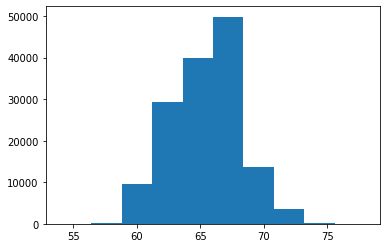

In [85]:
plt.hist(df['height'], bins=10)

In [86]:
df['weight']

0         137lbs
1         132lbs
3         135lbs
4         145lbs
5         138lbs
           ...  
192539    140lbs
192540    100lbs
192541    135lbs
192542    165lbs
192543    155lbs
Name: weight, Length: 146137, dtype: object

In [90]:
abc = re.split('\D+', '137lbs')[0]

In [91]:
abc

'137'

In [94]:
df['weight'] = df['weight'].str.split('\D+')

In [96]:
df['weight'] = df['weight'].apply(lambda x:x[0])

In [100]:
df['weight'] = df['weight'].astype('int32')

In [102]:
df.head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,cup_size
0,fit,420272,34,2260466,137,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,d
1,fit,273551,34,153475,132,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,b
3,fit,909926,34,126335,135,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,c
4,fit,151944,34,616682,145,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,b
5,fit,734848,32,364092,138,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68.0,8,45.0,b


In [130]:
df.to_csv(r'/Users/andrewtriola/Documents/flatiron/mod_6_proj/mod_6_project/updated_df2.csv')

(array([6.0000e+00, 0.0000e+00, 3.0000e+00, 2.0000e+01, 6.2400e+02,
        5.6860e+03, 1.7918e+04, 3.0620e+04, 3.2082e+04, 2.3095e+04,
        1.4819e+04, 9.4580e+03, 4.8470e+03, 2.8940e+03, 1.4680e+03,
        9.8900e+02, 5.8500e+02, 4.2200e+02, 2.1700e+02, 1.5000e+02,
        1.3300e+02, 5.7000e+01, 2.7000e+01, 1.2000e+01, 5.0000e+00]),
 array([ 50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140., 150.,
        160., 170., 180., 190., 200., 210., 220., 230., 240., 250., 260.,
        270., 280., 290., 300.]),
 <a list of 25 Patch objects>)

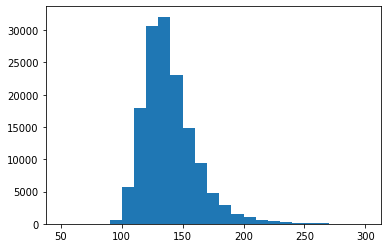

In [107]:
plt.hist(df['weight'], bins=25)

In [109]:
df['user_id'].value_counts()

691468    436
32925     292
45337     140
833675    128
742630    124
         ... 
122743      1
329580      1
606059      1
821084      1
637431      1
Name: user_id, Length: 77237, dtype: int64

In [112]:
condition1 = df['user_id'] == 45337

In [121]:
condition2 = df['rented_for'] != 'party: cocktail'

In [122]:
df = df[condition2]

In [128]:
##regroup categories (reduce from 68 to 7)
recat1 = df.replace(['dress', 'sheath', 'shirtdress', 'shift', 'ballgown', 'frock', 'kaftan', 'caftan', 'gown', 'print'], 'dresses')
recat2 = recat1.replace(['romper', 'jumpsuit', 'overalls', 'combo', 'suit'], 'jumpsuits')
recat3 = recat2.replace(['jogger', 'trousers', 'tight', 'jeans', 'sweatpants', 'leggings', 'pants', 'culottes', 'legging', 'pant', 'culotte', 'trouser'], 'pants')
recat4 = recat3.replace(['sweater', 'duster', 'cardigan', 'sweatshirt', 'pullover', 'turtleneck', 'hoodie', 'sweatershirt'], 'sweaters')
recat5 = recat4.replace(['jacket', 'coat', 'trench', 'cape', 'bomber', 'blazer', 'vest', 'poncho', 'down', 'parka', 'peacoat', 'overcoat'], 'outerwear')
recat6 = recat5.replace(['top,', 'shirt', 'blouse', 'tank', 'tunic', 'knit', 'tee', 'henley', 'blouson', 't-shirt', 'kimono', 'cami', 'crewneck', 'buttondown', 'for'], 'tops')
recat7 = recat6.replace(['mini', 'skirt', 'maxi','midi', 'skirts', 'skort'], 'skirts')
recat8 = recat7.replace(['top'], 'tops')

##rename recategorized df variable
df = recat8

In [55]:
dress_condition = ((df['category'] == 'dress') | (df['category'] == 'sheath') | (df['category'] == 'shirtdress') | 
(df['category'] == 'shift') | (df['category'] == 'ballgown') | (df['category'] == 'frock') | 
(df['category'] == 'kaftan') | (df['category'] == 'caftan') | (df['category'] == 'gown') | (df['category'] == 'print'))

In [58]:
dress_df = df[dress_condition]

In [51]:
df.category.value_counts()

dress           70341
gown            33240
sheath          14679
shift            4032
jumpsuit         4016
                ...  
sweatershirt        3
buttondown          1
sweatpants          1
crewneck            1
overcoat            1
Name: category, Length: 68, dtype: int64

In [4]:
user_df = df[['user_id', 'bust_size', 'cup_size', 'body_type', 'weight', 'height', 'age']].copy()

In [42]:
item_df = df[['item_id', 'rating', 'rented_for', 'category']].copy()

In [59]:
dress_item_df = dress_df[['item_id', 'rating', 'rented_for', 'category']].copy()

In [43]:
item_df.shape

(146136, 4)

In [7]:
user_df.head()

,user_id,bust_size,cup_size,body_type,weight,height,age
0,420272,34,d,hourglass,137,68.0,28.0
1,273551,34,b,straight & narrow,132,66.0,36.0
3,909926,34,c,pear,135,65.0,34.0
4,151944,34,b,athletic,145,69.0,27.0
5,734848,32,b,athletic,138,68.0,45.0


In [16]:
ratings_df = small_df[['user_id', 'item_id', 'rating']]

In [65]:
dress_ratings_df = dress_df[['user_id', 'item_id', 'rating']]

In [66]:
dress_ratings_df.head()

,user_id,item_id,rating
1,273551,153475,10.0
3,909926,126335,8.0
4,151944,616682,10.0
5,734848,364092,8.0
6,336066,568429,10.0


In [67]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(2.0, 10.0))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(dress_ratings_df, reader)

In [98]:
# We'll use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4261  1.4034  1.4096  1.4136  1.4054  1.4116  0.0081  
MAE (testset)     1.1156  1.1057  1.1083  1.1075  1.1073  1.1089  0.0035  
Fit time          5.65    6.09    6.07    5.70    5.68    5.84    0.20    
Test time         0.19    0.18    0.17    0.37    0.17    0.22    0.07    


{'test_rmse': array([1.42614195, 1.40343488, 1.40956572, 1.41355903, 1.40541337]),
 'test_mae': array([1.11564013, 1.10572629, 1.10826126, 1.10753193, 1.10730007]),
 'fit_time': (5.654374837875366,
  6.088383913040161,
  6.068114995956421,
  5.703299283981323,
  5.67799711227417),
 'test_time': (0.19176411628723145,
  0.18484783172607422,
  0.16997218132019043,
  0.366351842880249,
  0.17386484146118164)}

In [68]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

In [69]:
# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.3586


1.3586051762440219

In [11]:
### grid search ###

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.3982597328630135
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [44]:
###one hot encode item df
items_dummies = pd.get_dummies(item_df)
items_dummies.head()

,item_id,rating,rented_for_date,rented_for_everyday,rented_for_formal affair,rented_for_other,rented_for_party,rented_for_vacation,rented_for_wedding,rented_for_work,...,category_tank,category_tee,category_tight,category_top,category_trench,category_trouser,category_trousers,category_tunic,category_turtleneck,category_vest
0,2260466,10.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,153475,10.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,126335,8.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,616682,10.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,364092,8.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
###one hot encode item df
dress_items_dummies = pd.get_dummies(dress_item_df)
dress_items_dummies.head()

,item_id,rating,rented_for_date,rented_for_everyday,rented_for_formal affair,rented_for_other,rented_for_party,rented_for_vacation,rented_for_wedding,rented_for_work,category_ballgown,category_caftan,category_dress,category_frock,category_gown,category_kaftan,category_print,category_sheath,category_shift,category_shirtdress
1,153475,10.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,126335,8.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,616682,10.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
5,364092,8.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,568429,10.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [61]:
dress_items_dummies.shape

(123136, 20)

In [27]:
# cosine_similarity(items_dummies)

In [62]:
items_df_dress = dress_items_dummies.groupby(['item_id']).mean()

In [63]:
df.groupby(['item_id']).item_id.count().sort_values(ascending = False).head(50)

item_id
126335     1526
123793     1354
174086     1271
127865     1116
145906     1110
132738     1090
137585      884
136110      849
172027      829
131533      783
131117      738
152836      650
166633      643
125465      631
130259      618
124204      603
136860      546
154002      518
123373      498
1226293     435
125564      427
168592      419
146684      394
1076484     393
168610      388
152662      384
128959      383
139086      383
138431      381
153475      381
147594      366
127495      365
963476      362
124553      359
125424      357
144051      346
141688      345
132135      338
162634      328
134393      322
1859039     320
140321      315
143094      312
166006      311
148089      308
142179      305
134015      305
730008      304
755371      303
131698      295
Name: item_id, dtype: int64

In [6]:
df['item_count'] = df.groupby(['item_id'])['item_id'].transform('count')

In [7]:
df.head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,cup_size,item_count
0,fit,420272,34,2260466,137,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,jumpsuits,68.0,14,28.0,d,19
1,fit,273551,34,153475,132,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,dresses,66.0,12,36.0,b,381
3,fit,909926,34,126335,135,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dresses,65.0,8,34.0,c,1526
4,fit,151944,34,616682,145,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,dresses,69.0,12,27.0,b,89
5,fit,734848,32,364092,138,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dresses,68.0,8,45.0,b,21


In [8]:
condition3 = df['item_count'] < 20

In [9]:
len((df[df['item_count'] < 20])['item_id'].unique())

3876

In [10]:
small_df = df[condition3]

In [12]:
small_df.shape

(28649, 16)

In [63]:
items_df_dress.head()

,rating,rented_for_date,rented_for_everyday,rented_for_formal affair,rented_for_other,rented_for_party,rented_for_vacation,rented_for_wedding,rented_for_work,category_ballgown,category_caftan,category_dress,category_frock,category_gown,category_kaftan,category_print,category_sheath,category_shift,category_shirtdress
item_id,,,,,,,,,,,,,,,,,,,
123373,8.871486,0.004016,0.000000,0.632530,0.036145,0.054217,0.002008,0.269076,0.002008,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
123793,9.528804,0.005170,0.000000,0.618168,0.052437,0.041359,0.000000,0.281388,0.001477,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
124204,9.326700,0.021559,0.000000,0.227197,0.111111,0.533997,0.029851,0.072968,0.003317,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124553,8.529248,0.094708,0.000000,0.172702,0.111421,0.300836,0.008357,0.275766,0.036212,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125424,9.025210,0.053221,0.005602,0.134454,0.201681,0.434174,0.005602,0.154062,0.011204,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
cosine_similarity(items_df_dress)

array([[1.        , 0.99994794, 0.98545054, ..., 0.99990949, 0.97772782,
        0.99727442],
       [0.99994794, 1.        , 0.98647642, ..., 0.99987361, 0.97902814,
        0.99753147],
       [0.98545054, 0.98647642, 1.        , ..., 0.9855761 , 0.97952081,
        0.98850051],
       ...,
       [0.99990949, 0.99987361, 0.9855761 , ..., 1.        , 0.97796761,
        0.99654379],
       [0.97772782, 0.97902814, 0.97952081, ..., 0.97796761, 1.        ,
        0.97958823],
       [0.99727442, 0.99753147, 0.98850051, ..., 0.99654379, 0.97958823,
        1.        ]])